In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import h5py
from collections import OrderedDict

from matplotlib import mlab
from scipy.interpolate import interp1d

import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable

from models import TimeSeriesFCN, TimeSeriesGatedFCN

In [16]:
def apply_psd(signal_t, psd, sampling_rate=4096, apply_butter=False):
    """
    Take a signal in the time domain, and a precalculated Power Spectral
    Density, and color the signal according to the given PSD.

    Args:
        signal_t: A signal in time domain (i.e. a 1D numpy array)
        psd: A Power Spectral Density, e.g. calculated from the detector noise.
            Should be a function: psd(frequency)
        sampling_rate: Sampling rate of signal_t
        apply_butter: Whether or not to apply a Butterworth filter to the data.

    Returns: color_signal_t, the colored signal in the time domain.
    """

    # First set some parameters for computing power spectra
    signal_size = len(signal_t)
    delta_t = 1 / sampling_rate

    # Go into Fourier (frequency) space: signal_t -> signal_f
    frequencies = np.fft.rfftfreq(signal_size, delta_t)
    signal_f = np.fft.rfft(signal_t)

    # Divide by the given Power Spectral Density (PSD)
    # This is the 'whitening' = actually adding color
    color_signal_f = signal_f / (np.sqrt(psd(frequencies) / delta_t / 2))

    # Go back into time space: color_signal_f -> color_signal_t
    color_signal_t = np.fft.irfft(color_signal_f, n=signal_size)

    # In case we want to use a Butterworth-filter, here's how to do it:
    if apply_butter:

        # Define cut-off frequencies for the filter
        f_low = 42
        f_high = 800

        # Calculate Butterworth-filter and normalization
        numerator, denominator = butter(4, [f_low*2/4096, f_high*2/4096],
                                        btype="bandpass")
        normalization = np.sqrt((f_high - f_low) / (sampling_rate / 2))

        # Apply filter and normalize
        color_signal_t = filtfilt(numerator, denominator, color_signal_t)
        color_signal_t = color_signal_t / normalization

    return color_signal_t


def get_psd(real_strain, sampling_rate=4096):
    """
    Take a detector recording and calculate the Power Spectral Density (PSD).

    Args:
        real_strain: The detector recording to be used.
        sampling_rate: The sampling rate (in Hz) of the recording

    Returns:
        psd: The Power Spectral Density of the detector recordings
    """

    # Define some constants
    nfft = 2 * sampling_rate  # Bigger values yield better resolution?

    # Use matplotlib.mlab to calculate the PSD from the real strain
    power_spectrum, frequencies = mlab.psd(real_strain,
                                           NFFT=nfft,
                                           Fs=sampling_rate)

    # Interpolate it linearly, so we can re-sample the spectrum arbitrarily
    psd = interp1d(frequencies, power_spectrum)

    return psd

## Read in the strains

In [17]:
with h5py.File('../data/strain/H1_2017_4096.hdf5', 'r') as file:
    strain_H1 = np.array(file['strain/Strain'])
    
with h5py.File('../data/strain/L1_2017_4096.hdf5', 'r') as file:
    strain_L1 = np.array(file['strain/Strain'])

## Whiten the strains and downsample

In [18]:
psd_H1 = get_psd(strain_H1)
psd_L1 = get_psd(strain_L1)

In [19]:
white_H1 = apply_psd(strain_H1, psd_H1)
white_L1 = apply_psd(strain_L1, psd_L1)

In [20]:
# start = int((4096*(2048.6-30))/2)
# end = int((4096*(2048.6+30))/2)
start = int((4096*(2048.6-30))/2)
end = int((4096*(2048.6+30))/2)

final_H1 = white_H1[::2][start:end]
final_L1 = white_L1[::2][start:end]

## Build a timeseries object, swap axes, make torch Variable

In [21]:
timeseries = np.array([np.dstack((final_H1, final_L1))])
timeseries = np.swapaxes(timeseries, 1, 3)
timeseries = np.swapaxes(timeseries, 2, 3)
timeseries = np.squeeze(timeseries, axis=2)

x = Variable(torch.from_numpy(timeseries), volatile=True).float()

In [23]:
model = TimeSeriesGatedFCN()

# Load the model weights: A little cumbersome, because we don't have CUDA
# and GPU parallelization like during training time
weights_file = './weights/timeseries_weights_0700_1200_8k.net'
state_dict = torch.load(weights_file, map_location=lambda storage, loc: storage)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)

In [24]:
# %%timeit
y_pred = model.forward(x)
y_pred = y_pred.view((y_pred.size()[0], y_pred.size()[-1]))

In [25]:
y_pred = y_pred.data.numpy()

## Make plots

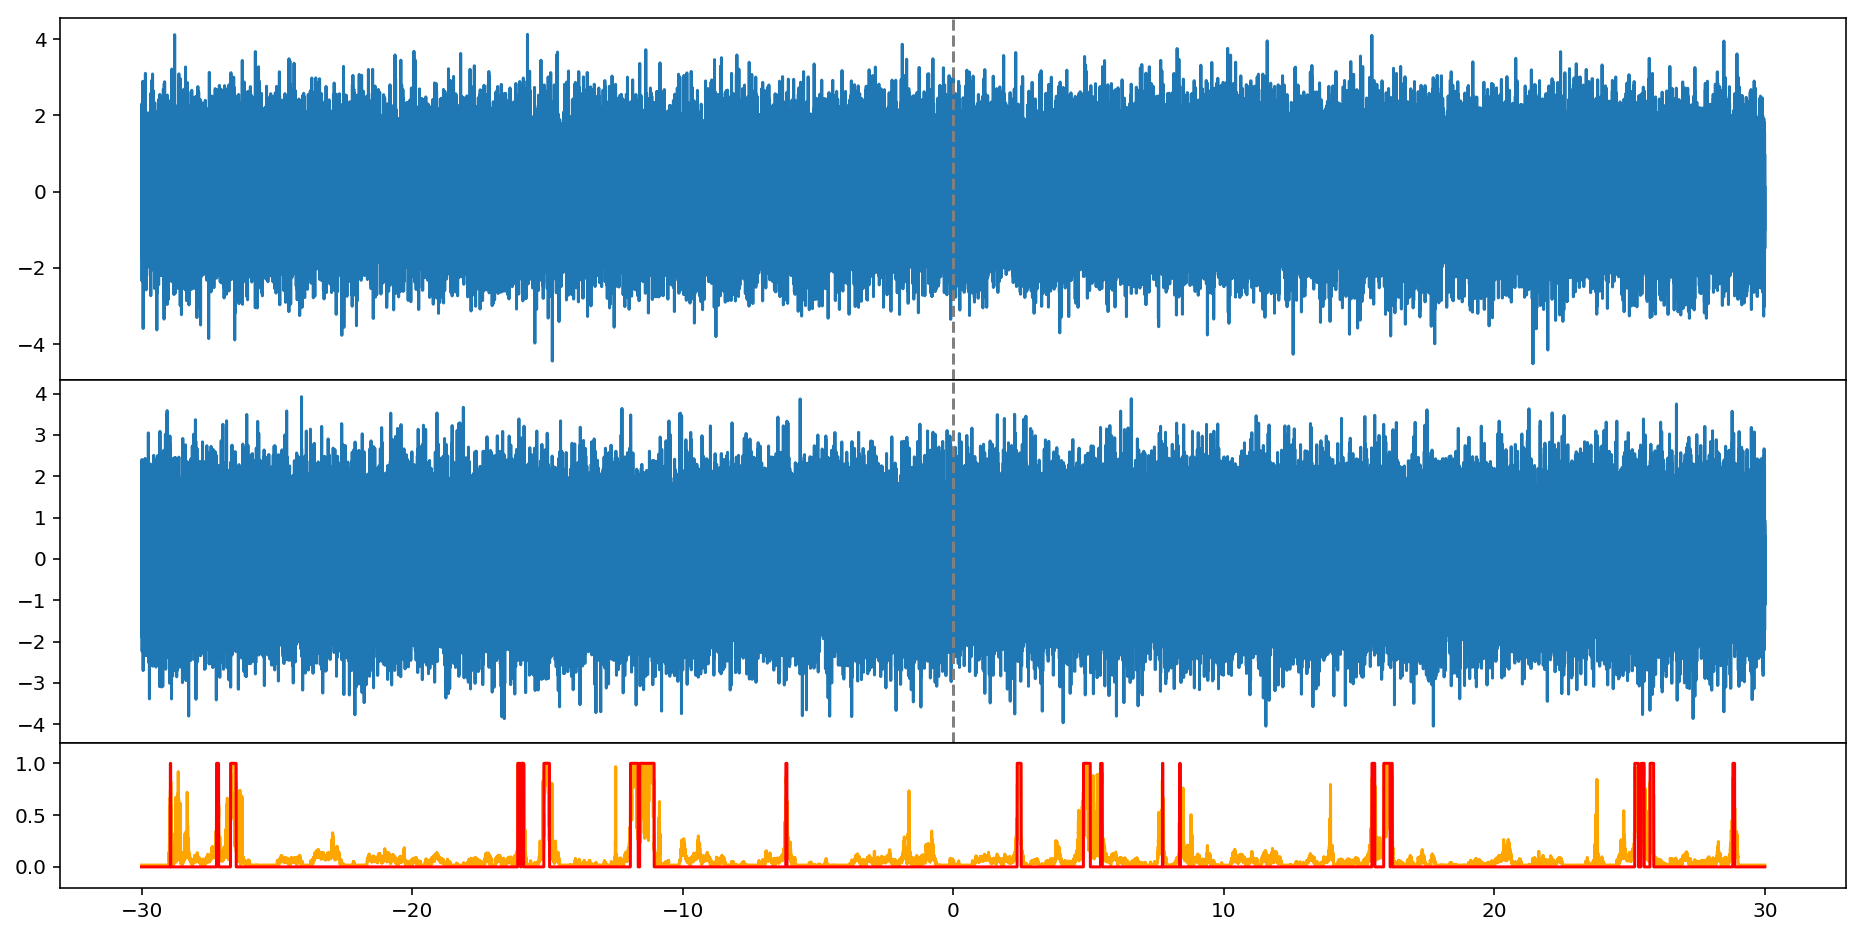

In [29]:
timeseries_H1 = timeseries[0, 0, :]
timeseries_L1 = timeseries[0, 1, :]

grid = np.linspace(-30, 30, 60*2048)
fig, axes = plt.subplots(nrows=3, ncols=1, sharex='col',
                         gridspec_kw={'height_ratios': [5, 5, 2]}, 
                         figsize=(16, 8))

axes[0].plot(grid, timeseries_H1)
axes[0].axvline(x=0, color='Gray', ls='--')

axes[1].plot(grid, timeseries_L1)
axes[1].axvline(x=0, color='Gray', ls='--')

axes[2].plot(grid, y_pred.reshape(-1), color='Orange')

smooth_pred = np.fromiter(map(lambda x: x>0.5, 
                              np.convolve(y_pred.reshape(-1), np.ones(100), mode='same')/100), 
                          dtype=np.float)
axes[2].plot(grid, smooth_pred, color='Red')

axes[2].set_ylim(-0.2, 1.2)
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

plt.show()